In [1]:
# Import programming libraries you may want to use
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from numpy import arange

from scipy.constants import c

import rioxarray as rio
import xarray as xr

import pandas as pd
import geopandas as gpd
from shapely import Point

import rasterio

import shapely
from shapely.geometry import LineString, MultiLineString, shape

In [2]:
def beamwidth(l=0.103986,D=8):
  """
  Approximate function to calculate beamwidth from the wavelength and the
  dish diameter.
  Input:
    l = wavelength (m)
    D = Dish diameter (m)
  Output:
    theta = beam width (degrees)
  """
  theta = (71.6*l)/D
  return(theta)

def maxrange(PRF=600):
  """
  Calculate the maximum unambiguous range.

  Input:
    PRF = pulse repetition frequency (Hz)
  Output:
    rmax = maximum unambiguous range (km)
  """
  rmax = c/(2*PRF)/1000
  return(rmax)

def maxvelocity(PRF=600, l=0.103986):
  """
  Calculate the maximum velocity that you can measure with a radar before
  aliasing occur.

  Input:
    PRF = pulse repetition frequency (Hz)
    l = wavelength (m)
  Output:
    Vmax = maximum velocity before aliasing (m/s)
  """
  Vmax = l*PRF/4
  return(Vmax)


In [3]:
def beamheight(r=1,deg=0):
  tha=math.radians(deg)
  return(math.sqrt(math.pow(r,2)+math.pow(Ri,2)+2*r*Ri*math.sin(tha))-Ri)

def create_beam(beamwidth=1,elevation=0.5,min=0,max=200):
  polygon=[]
  for x in arange(min,max+1,10):
    H=beamheight(r=x,deg=elevation)
    polygon.append((x,H))
  for x in arange(max,min-1,-10):
    H=beamheight(r=x,deg=elevation+beamwidth)
    polygon.append((x,H))
  return(polygon)

In [4]:
def xr_vectorize(da, 
                 attribute_col='attribute', 
                 transform=None, 
                 crs=None, 
                 dtype='float32',
                 export_shp=False,
                 verbose=False,
                 **rasterio_kwargs):    
    """
    Vectorises a xarray.DataArray into a geopandas.GeoDataFrame.
        
    """

    
    # Check for a crs object
    try:
        crs = da.crs
    except:
        if crs is None:
            raise Exception("Please add a `crs` attribute to the "
                            "xarray.DataArray, or provide a CRS using the "
                            "function's `crs` parameter (e.g. 'EPSG:3577')")
            
    # Check if transform is provided as a xarray.DataArray method.
    # If not, require supplied Affine
    if transform is None:
        try:
            # First, try to take transform info from geobox
            transform = da.geobox.transform
        # If no geobox
        except:
            try:
                # Try getting transform from 'transform' attribute
                transform = da.transform
            except:
                # If neither of those options work, raise an exception telling the 
                # user to provide a transform
                raise TypeError("Please provide an Affine transform object using the "
                                "`transform` parameter (e.g. `from affine import "
                                "Affine; Affine(30.0, 0.0, 548040.0, 0.0, -30.0, "
                                "6886890.0)`")
    
    # Check to see if the input is a numpy array
    if type(da) is np.ndarray:
        vectors = rasterio.features.shapes(source=da.astype(dtype),
                                           transform=transform,
                                           **rasterio_kwargs)
    
    else:
        # Run the vectorizing function
        vectors = rasterio.features.shapes(source=da.data.astype(dtype),
                                           transform=transform,
                                           **rasterio_kwargs)
    
    # Convert the generator into a list
    vectors = list(vectors)
    
    # Extract the polygon coordinates and values from the list
    polygons = [polygon for polygon, value in vectors]
    values = [value for polygon, value in vectors]
    
    # Convert polygon coordinates into polygon shapes
    polygons = [shape(polygon) for polygon in polygons]
    
    # Create a geopandas dataframe populated with the polygon shapes
    gdf = gpd.GeoDataFrame(data={attribute_col: values},
                           geometry=polygons,
                           crs=str(crs))
    
    # If a file path is supplied, export a shapefile
    if export_shp:
        gdf.to_file(export_shp) 
        
    return gdf

In [5]:
# Function to calculate great-circle distance using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # Earth radius in kilometers (change if needed)
    r = 6371.0
    return c * r



In [41]:
def beamheight(r=1,deg=0):
  tha=math.radians(deg)
  return(math.sqrt(math.pow(r,2)+math.pow(Ri,2)+2*r*Ri*math.sin(tha))-Ri)

def create_beam(beamwidth=1,elevation=0.5,min=0,max=200):
  polygon=[]
  for x in arange(min,max+1,10):
    H=beamheight(r=x,deg=elevation)
    polygon.append((x,H))
  for x in arange(max,min-1,-10):
    H=beamheight(r=x,deg=elevation+beamwidth)
    polygon.append((x,H))
  return(polygon)

# Function to create a polygon with hatching
def create_polygon(ax, vertices, hatch_pattern, colour):
  poly = Polygon(vertices, closed=True, fill=True, facecolor='black', edgecolor=colour, alpha=0.3)
  poly.set_hatch(hatch_pattern)
  ax.add_patch(poly)

def plotbeam(ax, beamwidth=1,elevation=0.5, hatch='|', color='black'):
  vertice=create_beam(beamwidth=beamwidth,elevation=elevation)
  create_polygon(ax,vertice,hatch,color)

In [42]:
beamwidth(0.103986,8)

0.9306746999999999

In [43]:
R=6374
Ri=4/3*R

In [44]:
angles=[0.5]

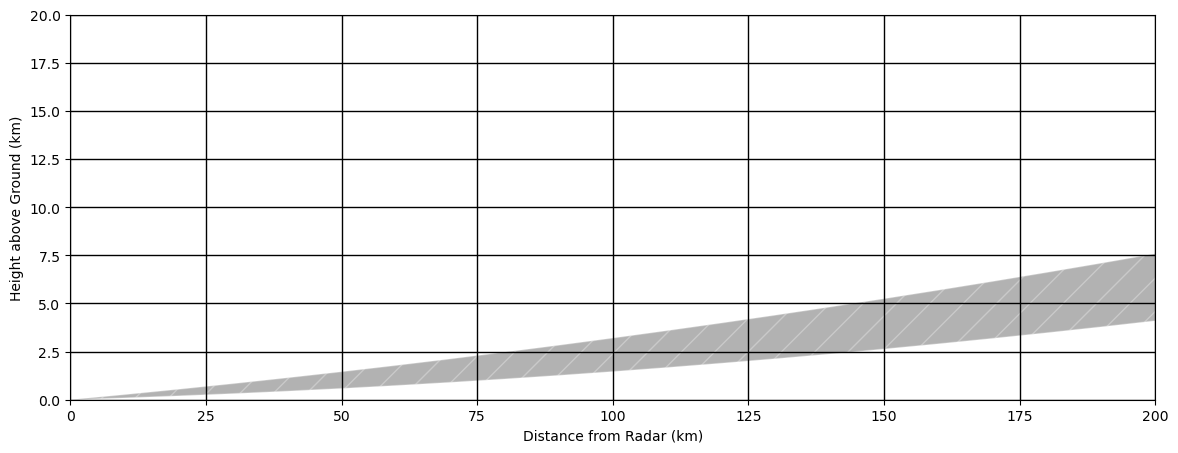

In [46]:
# Alternating hatch patterns , '|', '-', '+', 'x', 'o', 'O', '.', '*'
hatch_patterns = ['/', '\\']
colours=['white','white']

# Create the plot
fig, ax = plt.subplots(figsize=[14,5])

# Set labels for axes
ax.set_xlabel('Distance from Radar (km)')
ax.set_ylabel('Height above Ground (km)')

# Plot each beam
for i, angle in enumerate(angles):
    # Use modulo to cycle through hatch and colour patterns
    hatch_pattern = hatch_patterns[i % len(hatch_patterns)]
    colour = colours[i % len(colours)]
    #print(angle, hatch_pattern, colour)
    plotbeam(ax, 1, angle, hatch_pattern, colour)

# Set limits for x and y axes
ax.set_xlim(0, 200)  # adjust as needed
ax.set_ylim(0, 20)  # adjust as needed

# Show grid if you like
ax.grid(True, color='black', linewidth=1)

# Show the plot
plt.show()

## Import DEM

In [6]:
dem = xr.open_dataset('DEM_RadarRange.tif')

In [7]:
ds = dem.band_data[0]

In [8]:
R=6374
Ri=1560

# Radar coordinates (replace with actual radar coordinates)
radar_lon = 28.21
radar_lat = -25.91

# Define list of degrees
degrees = [0.5] #0.5, 1.3, 2.3, 3.4, 4.7, 6.2, 7.9, 9.9, 12.2, 16.8, 22, 30 

# Create an empty dataset to store the result
# Create an empty array to store the result
result = np.zeros(ds.shape)

# Iterate over each degree
for deg in degrees:
    # Compute distance from radar for each lat/lon point
    distance = haversine(ds.x, ds.y, radar_lon, radar_lat)

    # Apply the beamheight function to each lat/lon point using apply_ufunc
    beam_height = xr.apply_ufunc(
        beamheight,
        distance,
        vectorize=True,
        dask="parallelized",  # Use parallelized computation if using dask
        output_dtypes=[float],
        kwargs={"deg": deg},  # Pass the degree as a keyword argument
    )

    # Create mask based on elevation and beam height
    mask = ds > beam_height

In [10]:
# Create new dataset with band_1 based on the mask
new_dataset = xr.Dataset({"band_1": (("y", "x"), mask.data.astype(int))}, coords=ds.coords)

In [ ]:
gdf = xr_vectorize(new_dataset['band_1'], crs=new_dataset.rio.crs, transform=new_dataset.rio.transform(), mask=new_dataset['band_1'].values==1)

In [ ]:
gdf.to_file(f'radarcoverage_{degrees[0]}.shp')

In [35]:
import numpy as np
import xarray as xr
import math

def geo_to_polar(ds, radar_lon, radar_lat):
    # Ensure the dataset is aligned with radar coordinates
    ds_aligned = ds.sel(x=radar_lon, y=radar_lat, method='nearest')
    
    # Compute radial distance (range) and azimuth angle
    delta_x = ds_aligned.x.data - radar_lon
    delta_y = ds_aligned.y.data - radar_lat
    
    azimuth = np.arctan2(delta_x, delta_y)
    azimuth = np.degrees(azimuth) % 360
    
    range_km = 200 * np.sqrt(delta_x**2 + delta_y**2)  # Approximate conversion from degrees to kilometers
    
    # Create a new dataset with polar coordinates
    polar_ds = xr.Dataset(
        {
            "range_km": (("y", "x"), np.broadcast_to(range_km, ds.shape)),
            "azimuth_deg": (("y", "x"), np.broadcast_to(azimuth, ds.shape))
        },
        coords={"y": ds.y, "x": ds.x}
    )
    
    return polar_ds

# Assuming ds is your xarray dataset in geographic coordinates
# Assuming radar_x, radar_y are the radar's x and y coordinates, respectively
# Convert to polar coordinates
polar_ds = geo_to_polar(new_dataset.band_1, radar_lon, radar_lat)

In [36]:
polar_ds.azimuth_deg

<xarray.DataArray 'azimuth_deg' (y: 12904, x: 14463)>
array([[233.12028426, 233.12028426, 233.12028426, ..., 233.12028426,
        233.12028426, 233.12028426],
       [233.12028426, 233.12028426, 233.12028426, ..., 233.12028426,
        233.12028426, 233.12028426],
       [233.12028426, 233.12028426, 233.12028426, ..., 233.12028426,
        233.12028426, 233.12028426],
       ...,
       [233.12028426, 233.12028426, 233.12028426, ..., 233.12028426,
        233.12028426, 233.12028426],
       [233.12028426, 233.12028426, 233.12028426, ..., 233.12028426,
        233.12028426, 233.12028426],
       [233.12028426, 233.12028426, 233.12028426, ..., 233.12028426,
        233.12028426, 233.12028426]])
Coordinates:
  * y        (y) float64 -24.12 -24.12 -24.12 -24.12 ... -27.7 -27.7 -27.7 -27.7
  * x        (x) float64 26.2 26.2 26.2 26.2 26.2 ... 30.22 30.22 30.22 30.22

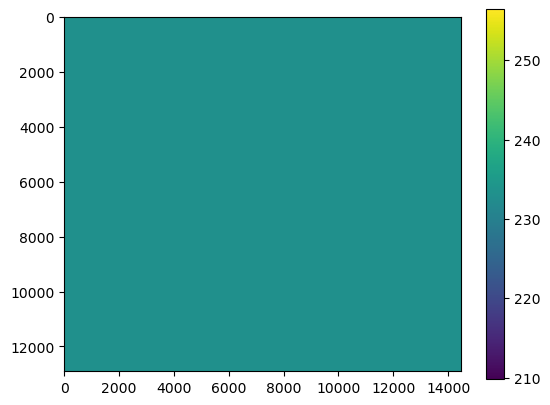

In [37]:
plt.imshow(polar_ds.azimuth_deg, cmap='viridis')
plt.colorbar()